In [1]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import datetime
from dateutil import parser
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit

from statsmodels.tsa.seasonal import seasonal_decompose as sd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

In [7]:
df_2009 = pd.read_excel('database/RESA_2009.xlsx', usecols=['datein', 'dateout', 'camping_label', 'los'])
df_2010 = pd.read_excel('database/RESA_2010.xlsx', usecols=['datein', 'dateout', 'camping_label', 'los'])
df_2011 = pd.read_excel('database/RESA_2011.xlsx', usecols=['datein', 'dateout', 'camping_label', 'los'])
df_2012 = pd.read_excel('database/RESA_2012.xlsx', usecols=['datein', 'dateout', 'camping_label', 'los'])
df_2013 = pd.read_excel('database/RESA_2013.xlsx', usecols=['datein', 'dateout', 'camping_label', 'los'])
df_2014 = pd.read_excel('database/RESA_2014.xlsx', usecols=['datein', 'dateout', 'camping_label', 'los'])
df_2015 = pd.read_excel('database/RESA_2015.xlsx', usecols=['datein', 'dateout', 'camping_label', 'los'])
df_2016 = pd.read_excel('database/RESA_2016.xlsx', usecols=['datein', 'dateout', 'camping_label', 'los'])
df_2017 = pd.read_excel('database/RESA_2017.xlsx', usecols=['datein', 'dateout', 'camping_label', 'los'])
df_2018 = pd.read_excel('database/RESA_2018.xlsx', usecols=['datein', 'dateout', 'camping_label', 'los'])
df_2019 = pd.read_excel('database/RESA_2019.xlsx', usecols=['datein', 'dateout', 'camping_label', 'los'])
df_2020 = pd.read_excel('database/RESA_2020.xlsx', usecols=['datein', 'dateout', 'camping_label', 'los'])

In [81]:
DF = [df_2009, df_2010, df_2011, df_2012, df_2013, df_2014, df_2015, df_2016, df_2017, df_2018, df_2019, df_2020]

In [104]:
camps = []
for df in DF:
    [camps.append(str(i)) for i in df['camping_label'].unique()]
camp_list = sorted(set(camps))
np.unique(camp_list)

array(['ALOHA', 'AVIGNON PARC', 'BAIE DE DOUARNENEZ', 'BALEARES SON BOU',
       'BASTIANE', 'BELLE PLAGE', 'BOIS DU CHATELAS', 'BORDEAUX LAC',
       'BOUT DU MONDE', 'BRASILIA', 'CAMPOLORO', 'CASTEL ROSE',
       'CHALETS DE LA MER', 'CHAPONNET', 'CHATEAU DE BOISSON', 'CHENAIE',
       'CHÂTEAU DE FONRIVES', 'CLUB FARRET', 'COSTA DO VIZIR',
       'COTE BLEUE', 'COTE DE NACRE', 'COUSPEAU', 'DEAUVILLE',
       'DOMAINE DARNAUTEILLE', 'DOMAINE DE DRANCOURT',
       "DOMAINE DE L'ESQUIRAS", "DOMAINE DE L'OREE",
       'DOMAINE DE LA FORET', 'DOMAINE DE LOUVAREL', 'DOMAINE DES BANS',
       'DOMAINE DINLY', 'DOMAINE DU COLOMBIER', 'DOMAINE SAINTE CECILE',
       'DONARRAYAN PARK', 'EN CHAMPAGNE', 'ESCAPADE', 'ETOILE DES NEIGES',
       'FAYOLAN', 'GAVINA', 'GORGES DU CHAMBON', 'GRAND PARIS',
       'GRANDE COSSE', 'GRANDS PINS', 'GRANGE DE MONTEILLAC', 'HARAS',
       'HAUTES COUTURES', 'HERMITAGE', 'ILBARRITZ', 'LA CAPRICIEUCE',
       'LA CLAIRIERE', 'LA ROCHE POSAY VACANCES', 'LAC DE 

# Time Analysis

### Time Analysis Functions

In [149]:
def serial_date_to_string(srl_no):
    new_date = datetime.datetime(1900,1,1,0,0) + datetime.timedelta(srl_no - 1)
    date_parsed = parser.parse(new_date.strftime("%Y-%m-%d"))
    return date_parsed
    
def epoch_day_to_time(srl_no):
    new_date = datetime.datetime(1900,1,1,0,0) + datetime.timedelta(srl_no - 1)
    return new_date.strftime("%Y-%m-%d")

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
months_occ = ['March', 'April', 'May', 'June', 'July', 'August', 'September', 'October']

def camp_occ_calculator(dfs, camp, plot=True):
    """
    gets dfs for a camp and calculate daily occ per specific date convertor.
    return df with  occ by calculate user arrival - depart dates 
    
    """
    
    df_camp = pd.DataFrame(columns=['datein', 'dateout', 'camping_label', 'los'])
    for df in dfs:
        add_df = df[df['camping_label'] == camp]
        df_camp = df_camp.append(add_df, ignore_index = True)      
        
    if np.dtype(df_camp['datein']) == float:
        df_camp['new_date_in'] = df_camp['datein'].apply(lambda x: serial_date_to_string(x))
        df_camp['new_date_out'] = df_camp['dateout'].apply(lambda x: serial_date_to_string(x))
    else:
        df_camp['new_date_in'] = df_camp['datein']
        df_camp['new_date_out'] = df_camp['dateout']

    season = pd.date_range(start=min(df_camp['new_date_in']),end=max(df_camp['new_date_out']))
    dict_dates = defaultdict(int)
    for date in season:
        dict_dates[date] = 0

    for index in df_camp.index:
        for j in range(int(df_camp['los'][index])):
            dict_dates[pd.Timestamp(df_camp['new_date_in'][index]) + pd.DateOffset(days=j)] += 1
    df_date = pd.DataFrame(index=dict_dates.keys(), data=dict_dates.values())
    df_date = df_date[df_date[0] != 0]
    
    if plot:
        plot_occ(df_date, camp)
        plot_daliy_occ(df_date)
        plot_daliy_occ(df_date, time='day')
        
    return df_date

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

def plot_occ(df, camp):
    """
    plot summarize occ data per interval
    """
    interval = ['M', 'd']
    year = list(map(str, (df.index.year.min(), df.index.year.max())))
    for i, t in enumerate(interval, 1):
        plt.subplot(1,2,i)
        df[0].resample(t).mean().plot(figsize=(15,5))
        plt.title(camp, fontsize=20)
        plt.ylabel(f'Occ: resample by {interval[i]}')
        

def plot_daliy_occ(df, time=None):
    """
    Gets Avg Occ per month for date indexed df
    params: df of specific camp for specific year
            time, if None plot by day of the month else by week
    return: daily avg occ plot
    """
    if time != None:
        time = df.index.dayofweek
        x_label = "Days of Week" 
    else:
        time = df.index.day
        x_label = "Days of Month" 
        
    df.groupby([time, df.index.month]).mean().unstack().plot(figsize=(10,5), label='Inline label')
    plt.title('Daily Occ')
    plt.ylabel('OCC')
    plt.xlabel(x_label)
    plt.legend(months, loc='best', bbox_to_anchor=(1,1))

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

def run_predictor(df, model, test_year=2019):
    """
    Combine train and test df i.e. past and the test future df, using specified model.
    shift data by 10 days to prepare new data frame for autoregressor models.
    params: train, past years of camp occupations data
            test, future year to test model on 
    returns: prediction score and sanity checks for splited data.
    """
    print(f'Dates range:\n{df.index.min()} -> {df.index.max()}\n')
    shifted_data = pd.DataFrame({f't{k}': df[0].shift(k) for k in range(30)})
    shifted_data = shifted_data[~shifted_data.isna().any(axis=1)]
    X = shifted_data.drop(columns='t0')
    y = shifted_data.t0
    print(*list(zip(('X shape: ', 'y shape: '), (X.shape, y.shape))), sep='\n')

    # Split Train Test
    X_train = X[X.index.year < test_year]
    X_test = X[X.index.year >= test_year]
    y_train = y[y.index.year < test_year]
    y_test = y[y.index.year >= test_year]
    print(*list(zip(('X_train shape: ', 'X_test shape: ', 'y_train shape: ', 'y_test shape: '),(X_train.shape, X_test.shape, y_train.shape, y_test.shape))), sep='\n')
    
    # Run predictor
    if model == ARIMA:
        reg = model(X_train, order=(1,1,1))
        reg.fit()
    else:
        reg = model
    
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    print(f'R2:\t{round(r2_score(y_test, y_pred),3)}\nRMSE:\t{round(mean_squared_error(y_test, y_pred),2)}')
        
    f, a = plt.subplots(1,1,figsize = (10,5), sharex=True)
    plt.bar(y_test.index.week, y_test, label='Observed')
    plt.bar(y_test.index.week, y_pred, label='Forecast', alpha=0.5)
    plt.ylabel('Occ.')
    plt.xlabel('Date')
    plt.title('Prediction vs Past model Evaluation')
    plt.legend()
    
    
#     return X_train, X_test, y_train, y_test

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 



## Analysis Per Camp

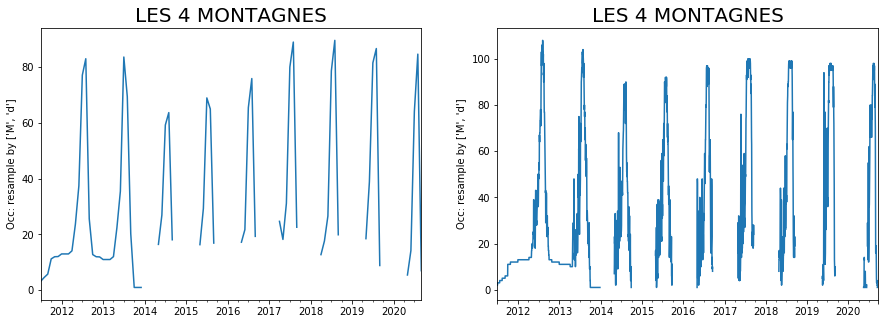

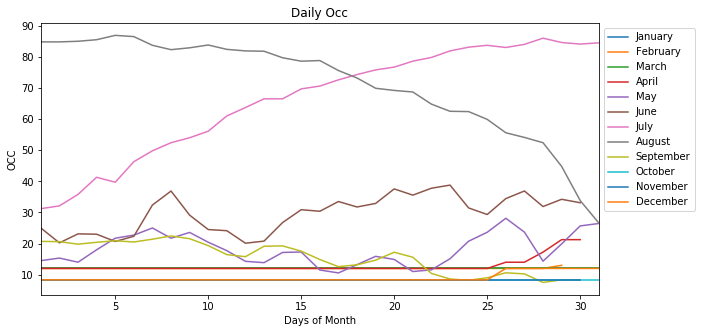

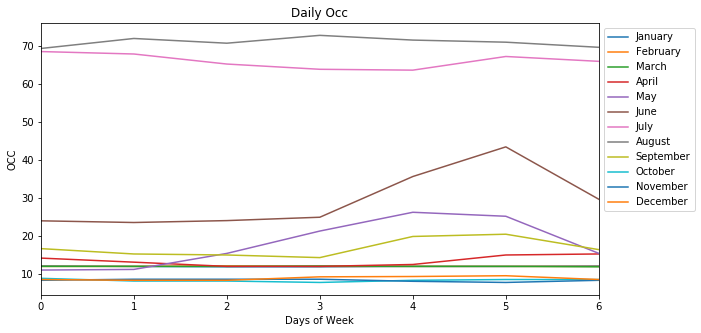

In [106]:
df_les4montage = camp_occ_calculator(DF, "LES 4 MONTAGNES")

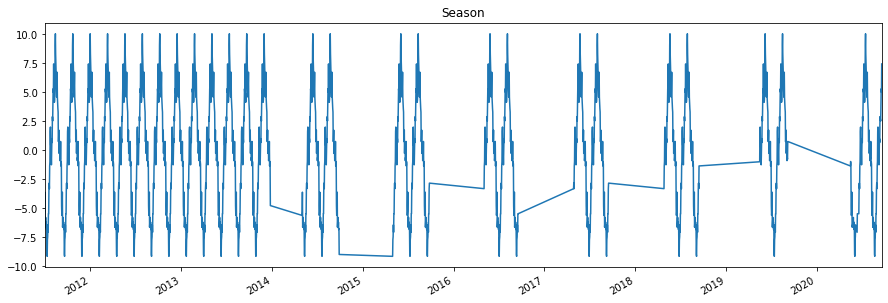

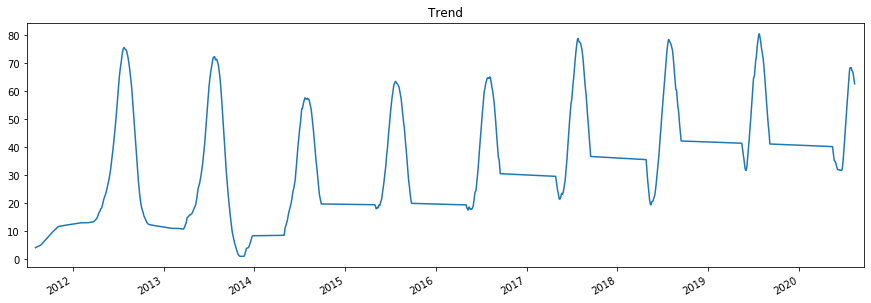

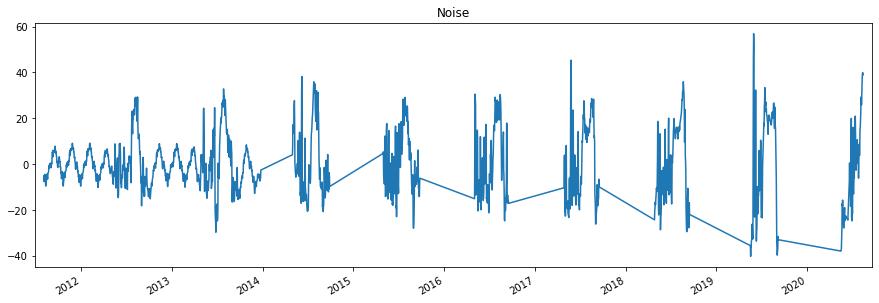

In [154]:
sd(df_les4montage, model='additive', freq=70).seasonal.plot(figsize=(15,5),legend=False)
plt.title('Season')
sd(df_les4montage, model='additive', freq=70).trend.plot(figsize=(15,5),legend=False)
plt.title('Trend')
sd(df_les4montage, model='additive', freq=70).resid.plot(figsize=(15,5),legend=False)
plt.title('Noise')
plt.show();

# plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1), fontsize=20);

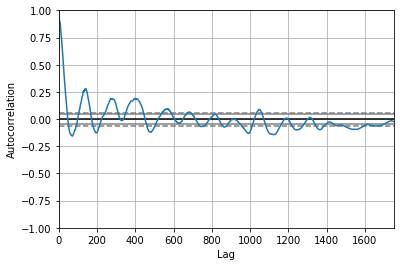

In [129]:
pd.plotting.autocorrelation_plot(df_les4montage)
plt.axis(xmin=0, xmax=1750);

Dates range:
2011-07-01 00:00:00 -> 2020-09-19 00:00:00

('X shape: ', (1828, 29))
('y shape: ', (1828,))
('X_train shape: ', (1602, 29))
('X_test shape: ', (226, 29))
('y_train shape: ', (1602,))
('y_test shape: ', (226,))
R2:	0.918
RMSE:	110.48


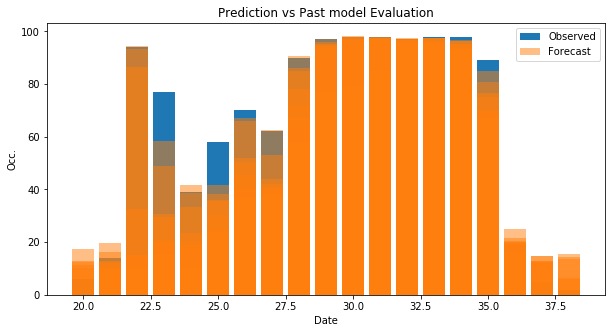

In [150]:
predict = run_predictor(df_les4montage, RandomForestRegressor(n_estimators=5000, oob_score=True, random_state=100))

# ARIMA model - AutoReg + Moving Avg

In [20]:
# First need to extract 
# AR lag (p)
# Moving Avg (Q)
# Integration (d = order of differentiation)

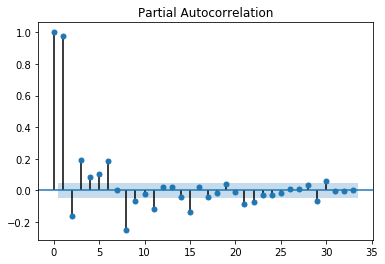

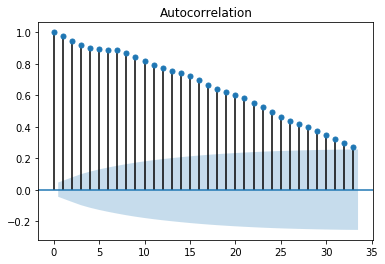

In [111]:
plot_pacf(df_les4montage);
plot_acf(df_les4montage);

# All Camps

In [ ]:
camps = camp_list[:3]
error = []
for camp in camps:
    try:
        print(f"\n\nTrain TS Analysis On 2018 {camp} Occ.\n\n")
        train = camp_occ_calculator(df_2018, camp)
        plt.show()
        print(f"\n\nTest TS Analysis On 2019 {camp} Occ.\n\n")
        test = camp_occ_calculator(df_2019, camp)
        plt.show()
        predict = run_predicator(train, test, RandomForestRegressor)
    except Exception as e:
        print(f"\n\nError {e} for {camp}\n\n")
        error.append(camp)
print(error)